# Laboratory 8:  Solution of the Quasi-geostrophic Equations using an Implicit Scheme #
## Lin Yang & John M. Stockie ##


## Contents ##

- [List of Problems](#List-of-Problems)
- [1. Objectives](#1.-Objectives)
- [2. Readings](#2.-Readings)
- [3. Introduction](#3.-Introduction)
- [4. The Quasi-Geostrophic Model](#4.-The-Quasi-Geostrophic-Model)
  * [4.1 Scaling the Equations of Motion](#4.1-Scaling-the-Equations-of-Motion)
- [5. Discretization of the QG equations](#5.-Discretization-of-the-QG-equations)
  * [5.1 Spatial Discretization](#5.1-Spatial-Discretization)
    - [5.1.1 Right Hand Side](#5.1.1-Right-Hand-Side)
    - [5.1.2 Boundary Conditions](#5.1.2-Boundary-Conditions)
    - [5.1.3 Matrix Form of the Discrete Equations](#5.1.3-Matrix-Form-of-the-Discrete-Equations)
  * [5.2 Solution of the Poisson Equation by Relaxation](#5.2-Solution-of-the-Poisson-Equation-by-Relaxation)
  * [5.3 Temporal Discretization](#5.3-Temporal-Discretization)
  * [5.4 Outline of the Solution Procedure](#5.4-Outline-of-the-Solution-Procedure)
- [6. Aliasing Error and Nonlinear Instability](#6.-Aliasing-Error-and-Nonlinear-Instability)
- [7. Classical Solutions](#7.-Classical Solutions)
- [A. Mathematical Notes](#A.-Mathematical-Notes)
  * [A.1 Definition of the Beta-plane](#A.1-Definition-of-the-Beta-plane)
  * [A.2 Simplification of the QG Model Equations](#A.2-Simplification-of-the-QG-Model-Equations)
- [Glossary](#Glossary)  
- [References](#References)

## List of Problems ##

- [Problem 1:](#Problem-One) Discretization of the Jacobian term
- [Problem 2:](#Problem-Two) Numerical instability in the “straightforward” Jacobian 
- [Problem 3:](#Problem-Three) Implement the SOR relaxation
- [Problem 4:](#Problem-Four) No-slip boundary conditions
- [Problem 5:](#Problem-Five) Starting values for the time integration
- [Problem 6:](#Problem-Six) Duplication of classical results

## 1. Objectives ##

This lab is an introduction to the use of implicit schemes for the
solution of PDE’s, using as an example the quasi-geostrophic equations
that govern the large-scale circulation of the oceans.

You will see that the discretization of the governing equations leads to
a large, sparse system of linear equations. The resulting matrix problem
is solved with relaxation methods, one of which you will write the code
for, by modifying the simpler Jacobi relaxation. There are two types of
boundary conditions typically used for this problem, one of which you
will program yourself – your computations are easily compared to
previously-obtained “classical” results.

## 2. Readings ##
There are no required readings for this lab. If you would like some
additional background beyond the material in the lab itself, then you
may refer to the references listed below:

-   **Equations of motion:**

    -   [Pedlosky](#Ref:Pedlosky) Sections 4.6 & 4.11 (derivation of QG
        equations)

-   **Nonlinear instability:**

    -   [Mesinger & Arakawa](#Ref:MesingerArakawa) (classic paper with
        description of instability and aliasing)

    -   [Arakawa & Lamb](#Ref:ArakawaLamb) (non-linear instability in the QG
        equations, with the Arakawa-Jacobian)

-   **Numerical methods:**

    -   [Strang](#Ref:Strang) (analysis of implicit schemes)

    -   [McCalpin](#Ref:Mccalpin) (QGbox model)

-   **Classical numerical results:**

    -   [Veronis](#Ref:Veronis) (numerical results)

    -   [Bryan](#Ref:Bryan) (numerical results)


In [1]:
from IPython.display import Image
# import the quiz script
from numlabs.lab8 import quiz8 as quiz

## 3. Introduction ##

An important aspect in the study of large-scale circulation in the ocean
is the response of the ocean to wind stress. Solution of this problem
using the full Navier-Stokes equations is quite complicated, and it is
natural to look for some way to simplify the governing equations. A
common simplification in many models of large-scale, wind-driven ocean
circulation, is to assume a system that is homogeneous and barotropic.

It is now natural to ask:

> *Does the simplified model capture the important dynamics in the
> real ocean?*

This question can be investigated by solving the equations numerically,
and comparing the results to observations in the real ocean. Many
numerical results are already available, and so the purpose of this lab
is to introduce you to the numerical methods used to solve this problem,
and to compare the computed results to those from some classical papers
on numerical ocean simulations.

Some of the numerical details (in Sections [5.1.1 Right Hand Side](#5.1.1-Right-Hand-Side), [5.1.2 Boundary Conditions](#5.1.2-Boundary-Conditions), [5.1.3 Matrix Form of Discrete Equations](#5.1.3-Matrix-Form-of-Discrete-Equations), [5.2 Solution of the Poisson Equation by Relaxation](#5.2-Solution-of-the-Poisson-Equation-by-Relaxation)
and the
appendices) are quite technical, and may be passed over the first time
you read through the lab. You can get a general idea of the basic
solution procedure without them. However, you should return to them
later and understand the material contained in them, since these
sections contain techniques that are commonly encountered when solving
PDE’s, and an understanding of these sections is required for you to
answer the problems in the Lab.


## 4. The Quasi-Geostrophic Model ##

Consider a rectangular ocean with a flat bottom, as pictured in
[Figure Model Ocean](#Figure-Model-Ocean), and ignore curvature effects, by confining the region of interest to a *mid-latitude $\beta$-plane*.

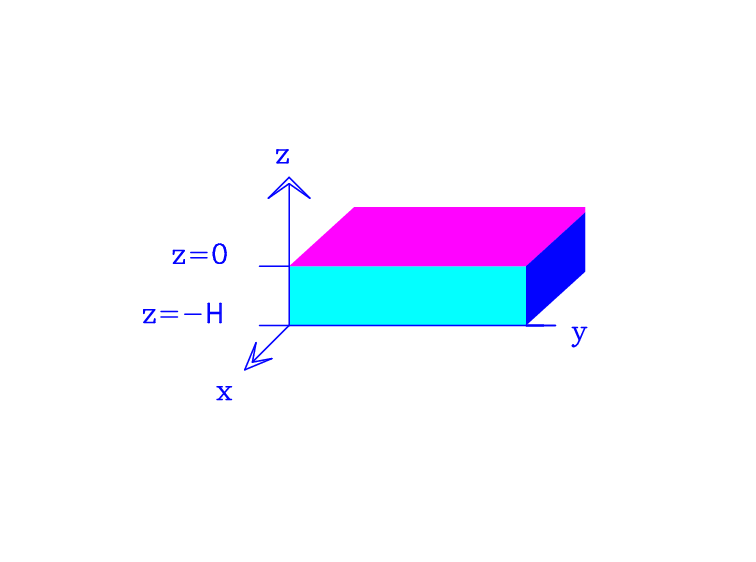

In [2]:
Image(filename='images/rect.png',width='45%') 

<div id='Figure-Model-Ocean'>
**Figure Model Ocean.** The rectangular ocean with flat bottom, ignoring curvature
effects.
</div>

More information on what is a $\beta$-plane and on the neglect of
curvature terms in the $\beta$-plane approximation is given in the
appendix.

If we assume that the ocean is homogeneous (it has constant density
throughout), then the equations governing the fluid motion on the
$\beta$-plane are: 

<a name='eq:xmom'></a>
(X-Momentum Eqn)
$$
  \frac {\partial u}{\partial t} + u \frac {\partial u}{\partial x} + v \frac {\partial u}{\partial y} + w \frac{\partial u}{\partial z} - fv = - \, \frac{1}{\rho} \, \frac {\partial p}{\partial x}
  + A_v \, \frac{\partial^2 u}{\partial z^2} + A_h \, \nabla^2 u
$$
<a name='eq:ymom'></a>
(Y-Momentum Eqn)
$$
  \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + w \frac{\partial v}{\partial z} + fu = - \, \frac{1}{\rho} \, \frac{\partial p}{\partial y}
  + A_v \, \frac{\partial^2 v}{\partial z^2} + A_h \, \nabla^2 v
$$
<a name='eq:hydrostatic'></a>
(Hydrostatic Eqn)
$$\frac{\partial p}{\partial z} = - \rho g$$
<a name='eq:continuity'></a>
(Continuity Eqn)
$$\frac {\partial u}{\partial x} + \frac{\partial v}{\partial y} = - \, \frac{\partial w}{\partial z}$$

where

-   ([X-Momentum Eqn](#eq:xmom)) and ([Y-Momentum Eqn](#eq:ymom)) are the lateral momentum equations,

-   ([Hydrostatic Eqn](#eq:hydrostatic)) is the hydrostatic balance (and replaces the vertical momentum
    equation), and

-   ([Continuity Eqn](#eq:continuity)) is the continuity (or incompressibility or conservation of volume) condition.

The variables and parameters appearing above are:

-   $(u,v,w)$, the fluid velocity components;

-   $f(y)$, the Coriolis parameter (assumed to be a linear function of
    $y$);

-   $\rho$, the density (assumed constant for a homogeneous fluid);

-   $A_v$ and $A_h$, the vertical and horizontal coefficients of
    viscosity, respectively (constants);

-   $g$, the gravitational acceleration (constant).

Equations ([X-Momentum Eqn](#eq:xmom)), ([Y-Momentum Eqn](#eq:ymom)), ([Hydrostatic Eqn](#eq:hydrostatic)) and ([Continuity Eqn](#eq:continuity)) form a non-linear system of PDE’s, for which there are many
numerical methods available. However, due to the complexity of the
equations, the methods themselves are *very complex*, and
consume a large amount of CPU time. It is therefore advantageous for us
to reduce the equations to a simpler form, for which common, and more
efficient numerical solution techniques can be used.


By applying a sequence of physically-motivated approximations (see
[Appendix A.2 Simplification of the QG Model Equations](#A.2-Simplification-of-the-QG-Model-Equations])) and by using the boundary conditions, the system([X-Momentum Eqn](#eq:xmom)), ([Y-Momentum Eqn](#eq:ymom)), ([Hydrostatic Eqn](#eq:hydrostatic)) and ([Continuity Eqn](#eq:continuity)) can be
reduced to a single PDE: 
<div id='eq:quasi'>
(Quasi-Geotrophic Eqn)
$$
  \frac{\partial}{\partial t} \, \nabla_h^2 \psi + {\cal J} \left( \psi, \nabla_h^2 \psi \right)
  + \beta \, \frac {\partial \psi}{\partial x} = \frac{1}{\rho H} \, \nabla_h \times \tau - \kappa
  \, \nabla_h^2 \psi + A_h \, \nabla_h^4 \psi $$
</div>  

  where

-   $\psi$ is the stream function, defined by
    $$u = - \frac{\partial \psi}{\partial y},$$
    $$v = \frac{\partial \psi}{\partial x}$$

-   $$\nabla_h = \left(\frac{\partial}{\partial x},\frac{\partial}{\partial y}\right)$$ 
    is the “horizontal”
    gradient operator, so-called because it involves only derivatives in
    $x$ and $y$;

-   $${\cal J} (a,b) = \frac{\partial a}{\partial x}  \frac{\partial
    b}{\partial y} - \frac{\partial a}{\partial y} \frac{\partial b}{\partial x}$$    
    is the *Jacobian* operator;

-   $\vec{\tau}(x,y) = \left(\,\tau_1(x,y),\tau_2(x,y)\,\right)$ is the
    wind stress boundary condition at the surface $z=0$. A simple form
    of the wind stress might assume an ocean “box” that extends from
    near the equator to a latitude of about $60^\circ$, for which
    typical winds are easterly near the equator and turn westerly at
    middle latitudes. A simple function describing this is
    $$\vec{\tau} = \tau_{max} (-\cos y, 0),$$ 
    which is what we will use in this lab. 
    
    More complicated wind stress functions are possible. See [McCalpin’s](#Ref:McCalpin)
    QGBOX documentation [p. 24] for another
    example.

-   $\beta = df/dy$ is a constant, where $f(y) = f_0+\beta y$ (see
    [Appendix A.1 Definition of the Beta-plane](#A.1-Definition-of-the-Beta-plane));

-   $\kappa = {1}/{H}  \left[ (A_v f_0)/{2} \right]^{1/2}$ is the bottom friction scaling (constant); and

-   $H$ is the vertical depth of the water column (constant).

Notice that the original (second order) system of four equations in four
unknowns ($u$, $v$, $w$, $p$) has now been reduced to a single (fourth
order) PDE in one unknown function, $\psi$. It will become clear in the
next section just how much simpler the system of equations has become …

Before going on, though, we need to close the system with the
*boundary conditions* for the stream function $\psi$. We
must actually consider two cases, based on whether or not the lateral
eddy viscosity parameter, $A_h$, is zero:

-   **if $A_h=0$:** the boundary conditions are
    *free-slip*; that is, $\psi=0$ on the boundary.

-   **if $A_h\neq 0$:** the boundary conditions are
    *no-slip*; that is both $\psi$ and its normal
    derivative $\nabla\psi\cdot\hat{n}$ are zero on the boundary (where
    $\hat{n}$ is the normal vector to the boundary).

### 4.1 Scaling the Equations of Motion ###

In physical problems, it is not uncommon for some of the quantities of
interest to differ in size by many orders of magnitude. This is of
particular concern when computing numerical solutions to such problems,
since then round-off errors can begin to pollute the computations (see
Lab 2).

This is also the case for the QG equations, where the parameters have a
large variation in size. The QG model parameters, and typical numerical
values, are given in [Table of Parameters](#tab:parameters). For such problems it is customary to *rescale* the
variables in such a way that the size differences are minimized.


**Problem Parameters**

| Symbol       | Name                        | Range of Magnitude                            | Units              |
| :----------: | :-------------------------: | :---------------------------------------: | :----------------: |
|   $R$        | Earth’s radius              | $6.4 \times 10^6$                         |  $m$               |
|$\Omega$      | Angular frequency for Earth | $7.27 \times 10^{-5}$                     | $s^{-1}$           |
|   $H$        | Depth of active layer       | $100 \rightarrow 4000$                    |  $m$               |
| $B$          | Length and width of ocean   | $1.0 \rightarrow 5.0 \times 10^6$         | $m$                |
| $\rho$       | Density of water            | $10^3$                                    | $kg/m^3$           |
| $A_h$        | Lateral eddy viscosity      | $0$ or $10^1 \rightarrow 10^4$            | $m^2/s$            |
| $A_v$        | Vertical eddy viscosity     | $10^{-4} \rightarrow 10^{-1}$             | $m^2/s$            |
| $\tau_{max}$ | Maximum wind stress         | $10^{-2} \rightarrow 1$                   | $kg m^{-1} s^{-2}$ |
| $\theta_0$   | Latitude                    | $0 \rightarrow \frac{\pi}{3}$             | -                  |

**Derived Quantities**

| Symbol       | Name                                          | Range of Magnitude                         | Units              |
| :----------: | :-------------------------------------------: | :----------------------------------------: | :----------------: |
| $\beta$      | $\beta =2\Omega \cos \theta_0 / R$            | $1.1 \rightarrow 2.3 \times 10^{-11}$ | $m^{-1} s^{-1}$    |
| $f_0$        | $f_0 = 2 \Omega \sin \theta_0$                | $0.0 \rightarrow 1.3 \times 10^{-4}$  | $s^{-1}$           |
| $U_0$        | Velocity scale = $\tau_{max}/(\beta\rho H B)$ | $10^{-5} \rightarrow 10^{-1}$         | $m s^{-1}$  | 
| $\kappa$     | bottom friction parameter                     | $0.0 \rightarrow 10^{-5}$             | $m^2 s^{-2}$  |

**Non-dimensional Quantities**

| Symbol / Name                                          | Range of Magnitude for Quantity              |
| :----------------------------------------------------: | :------------------------------------------: |
| $\epsilon$ / Vorticity ratio = $U_0/(\beta B^2)$       | (computed)                                   | 
| $\frac{\tau_{max}}{\epsilon\beta^2 \rho H B^3}$        | $10^{-12} \rightarrow 10^{-14}$              |
| $\frac{\kappa}{\beta B}$                               | $4 \times 10^{-4} \rightarrow 6 \times 10^1$ |
| $\frac{A_h}{\beta B^3}$                                | $10^{-7} \rightarrow 10^{-4}$                |

<div id='tab:parameters'>
**Table of Parameters**
</div>

Let us go through this scaling process for the evolution
equation [(Quasi-Geostrophic Eqn)](#eq:quasi) for the stream function, which is reproduced
here for easy comparison:

$$\frac{\partial}{\partial t} \nabla^2_h \psi = - \beta \frac{\partial \psi}{\partial x} - {\cal J}(\psi, \nabla_h^2\psi)+ \frac{1}{\rho H} \nabla_h \times \vec{\tau} - \kappa \nabla_h^2 \psi + A_h \nabla_h^4 \psi$$ 
  
The basic idea is to find typical
*scales of motion*, and then redefine the dependent and
independent variables in terms of these scales to obtain
*dimensionless variables*.

For example, the basin width and length, $B$, can be used as a scale for
the dependent variables $x$ and $y$. Then, we define dimensionless
variables 
<div id='eq:xscale'>
(x-scale eqn)
$$x^\prime = \frac{x}{B}$$
</div><div id='eq:yscale'>
(y-scale eqn)
$$y^\prime = \frac{y}{B}$$
</div>

Notice that where $x$ and $y$ varied between
0 and $B$ (where $B$ could be on the order of hundreds of kilometres),
the new variables $x^\prime$ and $y^\prime$ now vary between 0 and 1
(and so the ocean is now a unit square).

Similarly, we can redefine the remaining variables in the problem as
<div id='eq:tscale'>
(t-scale eqn)
$$
  t^\prime = \frac{t}{\left(\frac{1}{\beta B}\right)} $$
</div><div id='eq:psiscale'>
($\psi$-scale eqn)
$$  \psi^\prime = \frac{\psi}{\epsilon \beta B^3} $$
</div><div id='eq:tauscale'>
($\tau$-scale eqn)
$$  \vec{\tau}^\prime = \frac{\vec{\tau}}{\tau_{max}}
  $$</div>

where the scales have been
specially chosen to represent typical sizes of the variables. Here, the
parameter $\epsilon$ is a measure of the the ratio between the “relative
vorticity” ($\max|\nabla_h^2 \psi|$) and the planetary vorticity (given
by $\beta B$).

Now, we need only substitute for the original variables in the
equations, and replace derivatives with their dimensionless
counterparts; for example, using the chain rule,
$$\frac{\partial}{\partial x} = \frac{\partial x^\prime}{\partial x}
\frac{\partial}{\partial x^\prime}.$$ Then the equation of motion
becomes 

<a name='eq:qg-rescaled'></a>
(Rescaled Quasi-Geostrophic Eqn)
$$ \frac{\partial}{\partial t^\prime} \nabla^{\prime 2}_h \psi^\prime = - \, \frac{\partial \psi^\prime}{\partial x^\prime} - \epsilon {\cal J^\prime}(\psi^\prime, \nabla_h^{\prime 2}\psi^\prime) + \frac{\tau_{max}}{\epsilon \beta^2 \rho H B^3} \nabla^\prime_h \times \vec{\tau}^\prime - \, \frac{\kappa}{\beta B} \nabla_h^{\prime 2} \psi^\prime + \frac{A_h}{\beta B^3} \nabla_h^{\prime 4} \psi^\prime $$ 
  The superscript
“$\,^\prime$” on $\nabla_h$ and ${\cal J}$ signify that the derivatives
are taken with respect to the dimensionless variables. Notice that each
term in ([Rescaled Quasi-Geostrophic Eqn](#eq:qg-rescaled)) is now dimensionless, and that there are
now 4 dimensionless combinations of parameters $$\epsilon, \;\; 
\frac{\tau_{max}}{\epsilon \beta^2 \rho H B^3}, \;\;
\frac{\kappa}{\beta B}, \;\; \mbox{ and} \;\;
\frac{A_h}{\beta B^3}.$$ These four expressions define four new
dimensionless parameters that replace the original (unscaled) parameters
in the problem.

The terms in the equation now involve the dimensionless stream function,
$\psi^\prime$, and its derivatives, which have been scaled so that they
are now of order 1 in magnitude. The differences in sizes between terms
in the equation are now embodied solely in the four dimensionless
parameters. A term which is multiplied by a small parameter is thus
truly small in comparison to the other terms, and hence additive
round-off errors will not contribute substantially to a numerical
solution based on this form of the equations.

For the remainder of this lab, we will use the scaled version of the
equations. Consequently, the notation will be simplified by dropping the
“primes” on the dimensionless variables. But, **do not
forget**, that any solution (numerical or analytical) from the
scaled equations must be converted back into dimensional variables
using [the scale equations](#eq:xscale).

## 5. Discretization of the QG equations ##

At first glance, it is probably not clear how one might discretize the
QG equation ([Rescaled Quasi-Geostrophic Eqn](#eq:qg-rescaled)) from the previous section. This equation is an evolution
equation for $\nabla_h^2 \psi$ (the Laplacian of the stream function)
but has a right hand side that depends not only on $\nabla_h^2 \psi$,
but also on $\psi$ and $\nabla_h^4 \psi$. The problem may be written in
a more suggestive form, by letting $\chi = \partial\psi/\partial t$.
Then, the ([Rescaled Quasi-Geostrophic Eqn](#eq:qg-rescaled)) becomes 

<a name='eq:poisson'></a>
(Poisson Eqn)
$$\nabla_h^2 \chi = F(x,y,t), 
$$

where $F(x,y,t)$ contains all of the terms
except the time derivative. We will see that the discrete version of
this equation is easily solved for the new unknown variable $\chi$,
after which 
<div id='eq:dpsidt'>
$$\frac{\partial\psi}{\partial t} = \chi
$$</div>

may be used to evolve the stream function in
time.

The next two sections discuss the spatial and temporal discretization,
including some details related to the right hand side, the boundary
conditions, and the iterative scheme for solving the large sparse system
of equations that arises from the Poisson equation for $\chi$. Following
that is an summary of the steps in the solution procedure.



# 5.1 Spatial Discretization #

Assume that we are dealing with a square ocean, with dimensions
$1\times 1$ (in non-dimensional coordinates) and begin by dividing the
domain into a grid of discrete points
$$x_i = i \Delta x, \;\;i = 0, 1, 2, \dots, M$$
$$y_j = j \Delta y, \;\;j = 0, 1, 2, \dots, N$$ where $\Delta x = 1/M$
and $\Delta y = 1/N$. In order to simplify the discrete equations, it
will be helpful to assume that $M=N$, so that
$\Delta x = \Delta y \equiv d$. We can then look for approximate values
of the stream function at the discrete points; that is, we look for
$$\Psi_{i,j} \approx \psi(x_i,y_j)$$ (and similarly for $\chi_{i,j}$).
The computational grid and placement of unknowns is pictured in
Figure [Spatial Grid](#Spatial-Grid).

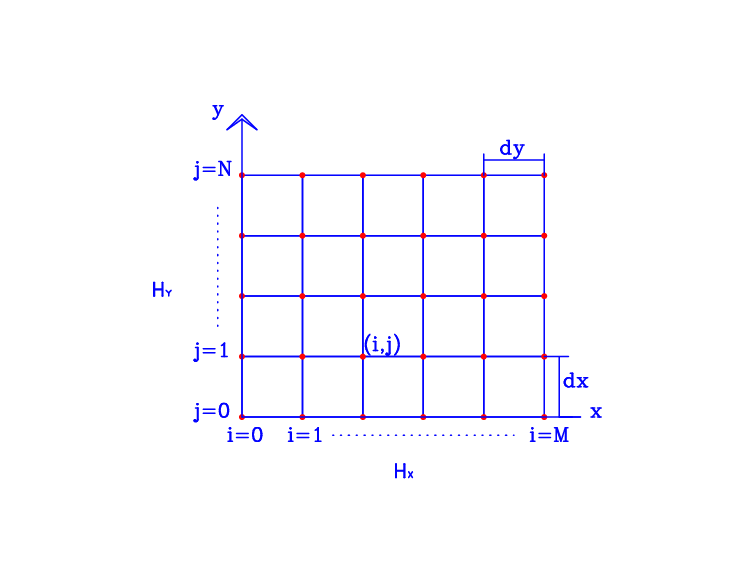

In [3]:
Image(filename='images/spatial.png',width='45%') 

<div id='Spatial-Grid'>
**Figure Spatial Grid**
</div>

Derivatives are replaced by their centered, second-order finite
difference approximations 
$$
  \left. \frac{\partial \Psi}{\partial x} \right|_{i,j}
  \approx 
  \frac{\Psi_{i+1,j}-\Psi_{i-1,j}}{2d}
  \left. \frac{\partial^2 \Psi}{\partial x^2} \right|_{i,j} 
  \approx
  \frac{\Psi_{i+1,j} - 2 \Psi_{i,j} + \Psi_{i-1,j}}{d^2}
$$ 
and similarly for the
$y$-derivatives. The discrete analogue of the ([Poisson equation](#eq:poisson)),
centered at the point $(x_i,y_j)$, may be written as
$$\frac{\chi_{i+1,j} - 2\chi_{i,j} +\chi_{i-1,j}}{d^2} + 
  \frac{\chi_{i,j+1} - 2\chi_{i,j} +\chi_{i,j-1}}{d^2}  = F_{i,j}$$ or,
after rearranging,

<a name='eq:discrete-chi'></a>
(Discrete $\chi$ Eqn)
$$\chi_{i+1,j}+\chi_{i-1,j}+\chi_{i,j+1}+\chi_{i,j-1}-4\chi_{i,j} =
  d^2F_{i,j}.
$$

Here, we’ve used
$F_{i,j} = F(x_i,y_j,t)$ as the values of the right hand side function
at the discrete points, and said nothing of how to discretize $F$ (this
will be left until [Section 5.1.1 Right Hand Side](#5.1.1-Right-Hand-Side). The ([Discrete $\chi$ equation](#eq:discrete-chi)) is an equation centered at the grid point $(i,j)$, and relating
the values of the approximate solution, $\chi_{i,j}$, at the $(i,j)$
point, to the four neighbouring values, as described by the *5-point difference stencil* pictured in
[Figure Stencil](#fig:stencil]).

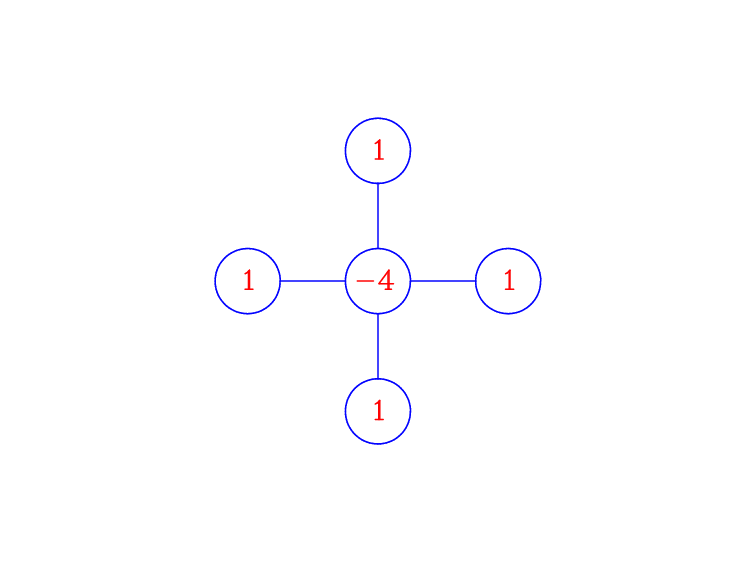

In [4]:
Image(filename='images/2diff.png',width='40%') 

<div id='fig:stencil'>
**Figure Stencil:**
The standard 5-point centered difference stencil for the Laplacian
(multiply by $\frac{1}{d^2}$ to get the actual coefficients. </div>

These stencil diagrams are a compact way of representing the information
contained in finite difference formulas. To see how useful they are, do
the following:

-   Choose the point on the grid in [Figure Spatial Grid](#Spatial-Grid) that
    you want to apply the difference formula ([Discrete $\chi$ Eqn](#eq:discrete-chi)).

-   Overlay the difference stencil diagram on the grid, placing the
    center point (with value $-4$) on this point.

-   The numbers in the stencil are the multiples for each of the
    unknowns $\chi_{i,j}$ in the difference formula.

An illustration of this is given in [Figure Overlay](#fig:overlay).

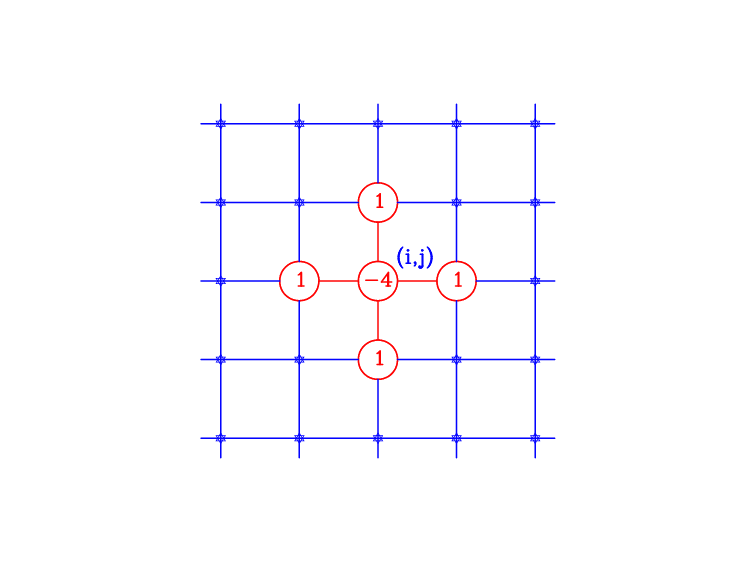

In [5]:
Image(filename='images/2diffgrid.png',width='40%') 

<div id='fig:overlay'>
**Figure Overlay:**
    The 5-point difference stencil overlaid on the grid.
    </div>
    
Before going any further with the discretization, we need to provide a
few more details for the discretization of the right hand side function,
$F(x,y,t)$, and the boundary conditions. If you’d rather skip these for
now, and move on to the time discretization
([Section 5.3 Temporal Discretization](#5.3-Temporal-Discretization))
or the outline of the solution procedure
([Section 5.4 Outline of Solution Procedure](#5.4-Outline-of-Solution-Procedure)), then you may do so now.

### 5.1.1 Right Hand Side ###

The right hand side function for the ([Poisson equation](#eq:poisson)) is reproduced here
in scaled form (with the “primes” dropped): 
$$F(x,y,t) = - \, \frac{\partial \psi}{\partial x} - \epsilon {\cal J}(\psi,\nabla_h^{2}\psi) + \frac{\tau_{max}}{\epsilon \beta^2 \rho H B^3} \nabla_h \times \vec{\tau} - \frac{\kappa}{\beta B} \nabla_h^{2} \psi + \frac{A_h}{\beta B^3} \nabla_h^{4} \psi$$

Alternatively, the Coriolis and Jacobian terms can be grouped together
as a single term: 
$$- \, \frac{\partial\psi}{\partial x} - \epsilon {\cal J}(\psi, \nabla^2_h\psi) = - {\cal J}(\psi, y + \epsilon \nabla^2_h\psi)$$

Except for the Jacobian term, straightforward second-order centered
differences will suffice for the Coriolis force
$$\frac{\partial\psi}{\partial x} \approx 
    \frac{1}{2d} \left(\Psi_{i+1,j} - \Psi_{i-1,j}\right),$$ 
    the wind
stress 
$$\nabla_h \times \vec{\tau} \approx
    \frac{1}{2d} \, 
    \left( \tau_{2_{i+1,j}}-\tau_{2_{i-1,j}} - 
      \tau_{1_{i,j+1}}+\tau_{1_{i,j-1}} \right),$$ and the second order
viscosity term $$\nabla_h^2 \psi \approx
     \frac{1}{d^2} \left( \Psi_{i+1,j}+\Psi_{i-1,j}+\Psi_{i,j+1} +
         \Psi_{i,j-1} - 4 \Psi_{i,j} \right).$$

The higher order (biharmonic) viscosity term, $\nabla_h^4 \psi$, is
slightly more complicated. The difference stencil can be derived in a
straightforward way by splitting into $\nabla_h^2 (\nabla_h^2 \psi)$ and
applying the discrete version of the Laplacian operator twice. The
resulting difference formula is 
<div id='eq:discrete-d4'>
(Bi-Laplacian)
$$ \nabla_h^4 \psi 
   =  \nabla_h^2 ( \nabla_h^2 \psi ) $$ $$
   \approx  \frac{1}{d^4} \left( \Psi_{i+2,j} + \Psi_{i,j+2} +
    \Psi_{i-2,j} + \Psi_{i,j-2} \right. + \, 2 \Psi_{i+1,j+1} + 2 \Psi_{i+1,j-1} + 2 \Psi_{i-1,j+1} +
    2 \Psi_{i-1,j-1}
   \left. - 8 \Psi_{i,j+1} - 8 \Psi_{i-1,j} - 8 \Psi_{i,j-1} - 8 \, \Psi_{i+1,j} + 20 \Psi_{i,j} \right)
  $$ </div> which is pictured in the
difference stencil in [Figure Bi-Laplacian Stencil](#fig:d4stencil).

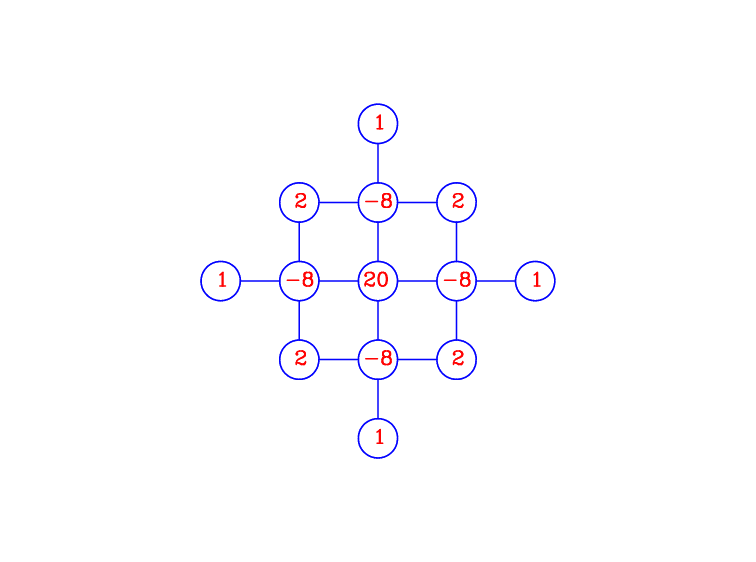

In [6]:
Image(filename='images/4diff.png',width='40%') 

<div id='fig:d4stencil'>
**Figure Bi-Laplacian Stencil:**
13-point difference stencil for the centered difference formula for
$\nabla_h^4$ (multiply by $\frac{1}{d^4}$ to get the actual
coefficients).</div>

The final term is the Jacobian term, ${\cal J}(\psi,
\nabla^2_h\psi)$ which, as you might have already guessed, is the one
that is going to give us the most headaches. To get a feeling for why
this might be true, go back to ([Rescaled Quasi-Geostropic Equation](#eq:qg-rescaled))  and notice that the only
nonlinearity arises from this term. Typically, it is the nonlinearity in
a problem that leads to difficulties in a numerical scheme. Remember the
formula given for ${\cal J}$ in the previous section:

<a name='eq:jacob1'></a>
(Jacobian: Expansion 1)
$${\cal J}(a,b) = \frac{\partial a}{\partial x} \, \frac{\partial b}{\partial y} - 
  \frac{\partial a}{\partial y} \, \frac{\partial b}{\partial x}
  $$

## *Problem One* ##
> Apply the standard centered difference formula
(see Lab 1 if you need to refresh you memory) to get a difference
approximation to the Jacobian based on ([Jacobian: Expansion 1](#eq:jacob1). You will use this later in
[Problem Two](#Problem-Two).

We’ve seen before that there is usually more than one way to discretize
a given expression. This case is no different, and there are many
possible ways to derive a discrete version of the Jacobian. Two other
approaches are to apply centered differences to the following equivalent
forms of the Jacobian: 
<div id='eq:jacob2'>
(Jacobian: Expansion 2)
$$
  {\cal J}(a,b) = \frac{\partial}{\partial x} \, \left( a \frac{\partial b}{\partial y} \right) -
    \frac{\partial}{\partial y} \left( a \frac{\partial b}{\partial x} \right)
    $$</div>
<div id='eq:jacob3'>
(Jacobian: Expansion 3)
$$
  {\cal J}(a,b) = \frac{\partial}{\partial y} \, \left( b \frac{\partial a}{\partial x} \right) -
    \frac{\partial}{\partial x} \left( b \frac{\partial a}{\partial y} \right)
    $$
   </div> 
    
Each formula leads to a different discrete formula, and we will see in
[Section 6. Aliasing Error and Nonlinear Instability](#6.-Aliasing-Error-and-Nonlinear-Instability)
 what effect the non-linear term has on
the discrete approximations and how the use of the different formulas
affect the behaviour of the numerical scheme. Before moving on, try to
do the following two quizzes.

## Quiz on Jacobian Expansion #2 ## 

Using second order centered differences, what is the discretization of the second form of the Jacobian given by

$$
  {\cal J}(a,b) = \frac{\partial}{\partial x} \, \left( a \frac{\partial b}{\partial y} \right) -
    \frac{\partial}{\partial y} \left( a \frac{\partial b}{\partial x} \right)
    $$

- A: $$\frac 1 {d^2} \left[ \left( a_{i+1,j} - a_{i-1,j} \right) \left( b_{i,j+1} - b_{i,j-1} \right) -    \left( a_{i,j+1} - a_{i,j-1} \right) \left( b_{i+1,j} - b_{i-1,j} \right) \right]$$

- B: $$\frac 1 {4d^2} \left[ a_{i+1,j} \left( b_{i+1,j+1} - b_{i+1,j-1} \right) - a_{i-1,j} \left( b_{i-1,j+1} - b_{i-1,j-1} \right) - a_{i,j+1} \left( b_{i+1,j+1} - b_{i-1,j+1} \right) + a_{i,j-1} \left( b_{i+1,j-1} - b_{i-1,j-1} \right) \right]$$

- C: $$\frac 1 {d^2} \left[ \left( a_{i+1/2,j} - a_{i-1/2,j} \right) \left( b_{i,j+1/2} - b_{i,j-1/2} \right) -    \left( a_{i,j+1/2} - a_{i,j-1/2} \right) \left( b_{i+1/2,j} - b_{i-1/2,j} \right) \right]$$

- D: $$\frac 1 {4d^2} \left[ b_{i+1,j} \left( a_{i+1,j+1} - a_{i+1,j-1} \right) - b_{i-1,j} \left( a_{i-1,j+1} - a_{i-1,j-1} \right) - b_{i,j+1} \left( a_{i+1,j+1} - a_{i-1,j+1} \right) + b_{i,j-1} \left( a_{i+1,j-1} - a_{i-1,j-1} \right) \right]$$

- E: $$\frac 1 {4d^2} \left[ a_{i+1,j+1} \left( b_{i+1,j+1} - b_{i+1,j-1} \right) - a_{i-1,j-1} \left( b_{i-1,j+1} - b_{i-1,j-1} \right) - a_{i+1,j+1} \left( b_{i+1,j+1} - b_{i-1,j+1} \right) + a_{i-1,j-1} \left( b_{i+1,j-1} - b_{i-1,j-1} \right) \right]$$

- F: $$\frac 1 {4d^2} \left[ \left( a_{i+1,j} - a_{i-1,j} \right) \left( b_{i,j+1} - b_{i,j-1} \right) -    \left( a_{i,j+1} - a_{i,j-1} \right) \left( b_{i+1,j} - b_{i-1,j} \right) \right]$$

- G: $$\frac 1 {4d^2} \left[ b_{i,j+1} \left( a_{i+1,j+1} - a_{i-1,j+1} \right) - b_{i,j-1} \left( a_{i+1,j-1} - a_{i-1,j-1} \right) - b_{i+1,j} \left( a_{i+1,j+1} - a_{i+1,j-1} \right) + b_{i-1,j} \left( a_{i-1,j+1} - a_{i-1,j-1} \right) \right]$$
                           
In the following, replace 'x' by 'A', 'B', 'C', 'D', 'E', 'F', 'G', or 'Hint'

In [7]:
print (quiz.jacobian_2(answer = 'x'))

Acceptable answers are 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Hint'


## Quiz on Jacobian Expansion #3 ## 

Using second order centered differences, what is the discretization of the third form of the Jacobian given by

$$
 {\cal J}(a,b) = \frac{\partial}{\partial y} \, \left( b \frac{\partial a}{\partial x} \right) -
    \frac{\partial}{\partial x} \left( b \frac{\partial a}{\partial y} \right)
    $$

- A: - A: $$\frac 1 {d^2} \left[ \left( a_{i+1,j} - a_{i-1,j} \right) \left( b_{i,j+1} - b_{i,j-1} \right) -    \left( a_{i,j+1} - a_{i,j-1} \right) \left( b_{i+1,j} - b_{i-1,j} \right) \right]$$

- B: $$\frac 1 {4d^2} \left[ a_{i+1,j} \left( b_{i+1,j+1} - b_{i+1,j-1} \right) - a_{i-1,j} \left( b_{i-1,j+1} - b_{i-1,j-1} \right) - a_{i,j+1} \left( b_{i+1,j+1} - b_{i-1,j+1} \right) + a_{i,j-1} \left( b_{i+1,j-1} - b_{i-1,j-1} \right) \right]$$

- C: $$\frac 1 {d^2} \left[ \left( a_{i+1/2,j} - a_{i-1/2,j} \right) \left( b_{i,j+1/2} - b_{i,j-1/2} \right) -    \left( a_{i,j+1/2} - a_{i,j-1/2} \right) \left( b_{i+1/2,j} - b_{i-1/2,j} \right) \right]$$

- D: $$\frac 1 {4d^2} \left[ b_{i+1,j} \left( a_{i+1,j+1} - a_{i+1,j-1} \right) - b_{i-1,j} \left( a_{i-1,j+1} - a_{i-1,j-1} \right) - b_{i,j+1} \left( a_{i+1,j+1} - a_{i-1,j+1} \right) + b_{i,j-1} \left( a_{i+1,j-1} - a_{i-1,j-1} \right) \right]$$

- E: $$\frac 1 {4d^2} \left[ a_{i+1,j+1} \left( b_{i+1,j+1} - b_{i+1,j-1} \right) - a_{i-1,j-1} \left( b_{i-1,j+1} - b_{i-1,j-1} \right) - a_{i+1,j+1} \left( b_{i+1,j+1} - b_{i-1,j+1} \right) + a_{i-1,j-1} \left( b_{i+1,j-1} - b_{i-1,j-1} \right) \right]$$

- F: $$\frac 1 {4d^2} \left[ \left( a_{i+1,j} - a_{i-1,j} \right) \left( b_{i,j+1} - b_{i,j-1} \right) -    \left( a_{i,j+1} - a_{i,j-1} \right) \left( b_{i+1,j} - b_{i-1,j} \right) \right]$$

- G: $$\frac 1 {4d^2} \left[ b_{i,j+1} \left( a_{i+1,j+1} - a_{i-1,j+1} \right) - b_{i,j-1} \left( a_{i+1,j-1} - a_{i-1,j-1} \right) - b_{i+1,j} \left( a_{i+1,j+1} - a_{i+1,j-1} \right) + b_{i-1,j} \left( a_{i-1,j+1} - a_{i-1,j-1} \right) \right]$$
                           
In the following, replace 'x' by 'A', 'B', 'C', 'D', 'E', 'F', 'G', or 'Hint'

In [8]:
print (quiz.jacobian_3(answer = 'x'))

Acceptable answers are 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Hint'


### 5.1.2 Boundary Conditions ###

One question that arises immediately when applying the difference
stencils in [Figure Stencil](#fig:stencil) and [Figure Bi-Laplacian Stencil](#fig:d4stencil)
is

> *What do we do at the boundary, where at least one of the nodes
> of the difference stencil lies outside of the domain?*

The answer to this question lies with the <span>*boundary
conditions*</span> for $\chi$ and $\psi$. We already know the boundary
conditions for $\psi$ from [Section 4. The Quasi-Geostrophic Model](#4.-The-Quasi-Geostrophic-Model):

Free slip:

>   The free slip boundary condition, $\psi=0$, is applied when $A_h=0$,
    which we can differentiate with respect to time to get the identical
    condition $\chi=0$. In terms of the discrete unknowns, this
    translates to the requirement that
>    $$\Psi_{0,j} = \Psi_{N,j} = \Psi_{i,0} = \Psi_{i,N} = 0 \;\;
      \mbox{ for} \; i,j = 0,1,\ldots,N,$$ 
      
>    and similarly for $\chi$. All
    boundary values for $\chi$ and $\Psi$ are known, and so we need only
    apply the difference stencils at *interior points* (see
    [Figure Ghost Points](#fig:ghost)). When $A_h=0$, the high-order viscosity
    term is not present, and so the only stencil appearing in the
    discretization is the 5-point formula (the significance of this will
    become clear when we look at no-slip boundary conditions).

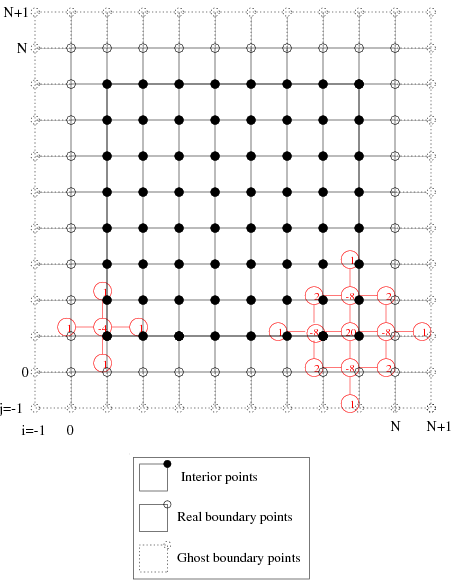

In [9]:
Image(filename='images/ghost3.png',width='50%') 

<div id='fig:ghost'>
**Figure Ghost Points:**
The points on the computational grid, which are classified into
    interior, real boundary, and ghost boundary points. The 5- and
    13-point difference stencils, when overlaid on the grid, demonstrate
    that only the real boundary values are needed for the free-slip
    boundary values (when $A_h=0$), while ghost points must be
    introduced for the no-slip conditions (when $A_h\neq 0$, and the
    higher order viscosity term is present).
</div>


No-slip:

>   The no-slip conditions appear when $A_h\neq 0$, and include the free
    slip conditions $\psi=\chi=0$ (which we already discussed above),
    and the normal derivative condition $\nabla\psi\cdot\hat{n}=0$,
    which must be satisfied at all boundary points. It is clear that if
    we apply the standard, second-order centered difference
    approximation to the first derivative, then the difference stencil
    extends *beyond the boundary of the domain and contains at
    least one non-existent point! How can we get around this
    problem?*

>    The most straightforward approach (and the one we will use in this
    Lab) is to introduce a set of *fictitious points* or
    *ghost points*,
    
>    $$\Psi_{-1,j}, \;\; \Psi_{N+1,j}, \;\; \Psi_{i,-1}, \;\; \Psi_{i,N+1}$$

>    for $i,j=0,1,2,\ldots,N+1$, which extend one grid space outside of
    the domain, as shown in [Figure Ghost Points](#fig:ghost). We can then
    discretize the Neumann condition in a straightforward manner. For
    example, consider the point $(0,1)$, pictured in
    [Figure No Slip Boundary Condition](#fig:noslip), at which the discrete version of
    $\nabla\psi\cdot\hat{n}=0$ is

>    $$\frac{1}{2d} ( \Psi_{1,1} - \Psi_{-1,1}, \Psi_{0,2} -
      \Psi_{0,0} ) \cdot (-1,0) = 0,$$ 
      
>   (where $(-1,0)$ is the unit
    outward normal vector), which simplifies to
    
>    $$\Psi_{-1,1} = \Psi_{1,1}.$$

>   The same can be done for all the
    remaining ghost points: the value of $\Psi$ at at point outside the
    boundary is given quite simply as the value at the corresponding
    interior point reflected across the boundary.


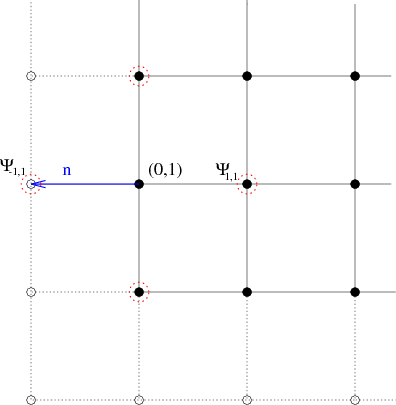

In [10]:
Image(filename='images/noslip.png',width='40%') 

<div id="fig:noslip">
**Figure No Slip Boundary Condition:**
The discrete Neumann boundary conditions are discretized using
    ghost points. Here, at point $(0,1)$, the unit outward normal vector
    is $\hat{n}=(-1,0)$, and the discrete points involved are the four
    points circled in red. The no-slip condition simply states that
    $\Psi_{-1,1}$ is equal to the interior value $\Psi_{1,1}$.
</div>

Now, remember that when $A_h\neq 0$, the $\nabla_h^4\psi$ term
    appears in the equations, which is discretized as a 13-point
    stencil . Looking at [Figure Ghost Points](#fig:ghost), it is easy to see that
    when the 13-point stencil is applied at points adjacent to the
    boundary (such as $(N-1,N-1)$ in the Figure) it involves not only
    real boundary points, but also ghost boundary points (compare this
    to the 5-point stencil). But, as we just discovered above, the
    presence of the ghost points in the stencil poses no difficulty,
    since these values are known in terms of interior values of $\Psi$
    using the boundary conditions.
    
Just as there are many Runge-Kutta schemes, there are many finite difference stencils for the different derivatives.
For example, one could use a 5-point, $\times$-shaped stencil for $\nabla^2\psi$. The flexibility of
having several second-order stencils is what makes it possible to determine an energy- and enstrophy-conserving scheme for the Jacobian which we do later.

A good discussion of boundary conditions is given by [McCalpin](#Ref:McCalpin) in his
QGBOX code documentation, on page 44.

### 5.1.3 Matrix Form of the Discrete Equations ###

In order to write the discrete equations  in matrix form, we must first
write the unknown values $\chi_{i,j}$ in vector form. The most obvious
way to do this is to traverse the grid (see
[Figure Spatial Grid](#Spatial-Grid)), one row at a time, from left to right,
leaving out the known, zero boundary values, to obtain the ordering:
$$
  \vec{\chi} =
  \left(\chi_{1,1},\chi_{2,1},\dots,\chi_{N-1,1},
    \chi_{1,2},\chi_{2,2},\dots,\chi_{N-1,2}, \dots, \right. 
 \left.\chi_{N-1,N-2},
    \chi_{1,N-1},\chi_{2,N-1},\dots,\chi_{N-1,N-1}\right)^T$$
    
and similarly for $\vec{F}$. The resulting matrix (with this ordering of
unknowns) results in a matrix of the form given in
[Figure Matrix](#fig:matrix).

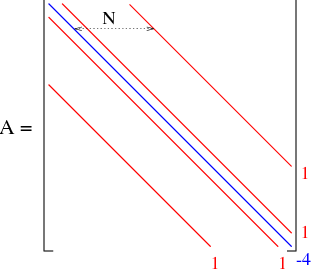

In [11]:
Image(filename='images/matrix.png',width='40%') 

<div id='fig:matrix'>
**Figure Matrix:** The matrix form for the discrete Laplacian. The 5 diagonals (displayed
in blue and red) represent the non-zero values in the matrix $-$ all
other values are zero.
</div>

The diagonals with the 1’s (pictured in red) contain some zero entries
due to the boundary condition $u=0$. Notice how similar this matrix
appears to the *tridiagonal matrix* in the Problems from
Lab 3, which arose in the discretization of the second derivative in a
boundary value problem. The only difference here is that the Laplacian
has an additional second derivative with respect to $y$, which is what
adds the additional diagonal entries in the matrix.

Before you think about running off and using Gaussian elimination (which
was reviewed in Lab 3), think about the size of the matrix you would
have to solve. If $N$ is the number of grid points, then the matrix is
size $N^2$-by-$N^2$. Consequently, Gaussian elimination will require on
the order of $N^6$ operations to solve the matrix only once. Even for
moderate values of $N$, this cost can be prohibitively expensive. For
example, taking $N=101$ results in a $10000\times 10000$ system of
linear equations, for which Gaussian elimination will require on the
order of $10000^3=10^{12}$ operations! As mentioned in Lab 3, direct
methods are not appropriate for large sparse systems such as this one. A
more appropriate choice is an iterative or *relaxation
scheme*, which is the subject of the next section..

### 5.2 Solution of the Poisson Equation by Relaxation ###

One thing to notice about the matrix in [Figure Matrix](#fig:matrix) is that
it contains many zeros. Direct methods, such as Gaussian elimination
(GE), are so inefficient for this problem because they operate on all of
these zero entries (in fact, there are other direct methods that exploit
the sparse nature of the matrix to reduce the operation count, but none
are as efficient as the methods we will talk about here).

However, there is another class of solution methods, called
*iterative methods* (refer to Lab 3) which are natural
candidates for solving such sparse problems. They can be motivated by
the fact that since the discrete equations are only approximations of
the PDE to begin with, *why should we bother computing an exact
solution to an approximate problem?* Iterative methods are based
on the notion that one sets up an iterative procedure to compute
successive approximations to the solution $-$ approximations that get
closer and closer to the exact solution as the iteration proceeds, but
never actually reach the exact solution. As long as the iteration
converges and the approximate solution gets to within some tolerance of
the exact solution, then we are happy! The cost of a single iterative
step is designed to depend on only the number of non-zero elements in
the matrix, and so is considerably cheaper than a GE step. Hence, as
long as the iteration converges in a “reasonable number” of steps, then
the iterative scheme will outperform GE.

Iterative methods are also know as *relaxation methods*, of
which the *Jacobi method* is the simplest. Here are the
basic steps in the Jacobi iteration (where we’ve dropped the time
superscript $p$ to simplify the notation):

1.  Take an initial guess, $\chi_{i,j}^{(0)}$. Let $n=0$.

2.  For each grid point $(i,j)$, compute the *residual
    vector* $$ R_{i,j}^{(n)} = F_{i,j} - \nabla^2\chi^{(n)}_{i,j} $$ 
    $$ = F_{i,j} - \frac{1}{d^2} ( \chi_{i+1,j}^{(n)} + \chi_{i,j+1}^{(n)} + \chi_{i-1,j}^{(n)} +\chi_{i,j-1}^{(n)} - 4 \chi_{i,j}^{(n)} )$$ (which is non-zero unless $\chi_{i,j}$ is the
    exact solution).

    You should not confuse the relaxation iteration index (superscript
    $\,^{(n)}$) with the time index (superscript $\,^p$). Since the
    relaxation iteration is being performed at a single time step, we’ve
    dropped the time superscript for now to simplify notation. Just
    remember that all of the discrete values in the relaxation are
    evaluated at the current time level $p$.

3.  “Adjust” $\chi_{i,j}^{(n)}$, (leaving the other neighbours
    unchanged) so that $R_{i,j}^{(n)}=0$. That is, replace
    $\chi_{i,j}^{(n)}$ by whatever you need to get a zero residual. This
    replacement turns out to be:
    $$\chi_{i,j}^{(n+1)} = \chi_{i,j}^{(n)} - \frac{d^2}{4} R_{i,j}^{(n)},$$ which defines the iteration.

4.  Set $n\leftarrow n+1$, and repeat steps 2 & 3 until the residual is
    less than some tolerance value. In order to measure the size of the
    residual, we use a *relative maximum norm* measure,
    which says
    $$d^2 \frac{\|R_{i,j}^{(n)}\|_\infty}{\|\chi_{i,j}^{(n)}\|_\infty} < TOL$$
    where $$\|R_{i,j}^{(n)}\|_\infty = \max_{i,j} |R_{i,j}^{(n)}|$$ is
    the *max-norm* of $R_{i,j}$, or the maximum value of
    the residual on the grid (there are other error tolerances we could
    use but this is one of the simplest and most effective). Using this
    measure for the error ensures that the residual remains small
    *relative* to the solution, $\chi_{i,j}$. A typical
    value of the tolerance that might be used is $TOL=10^{-4}$.

There are a few **important things** to note about the
basic relaxation procedure outlined above

-   This Jacobi method is the simplest form of relaxation. It requires
    that you have two storage vectors, one for $\chi_{i,j}^{(n)}$ and
    one for $\chi_{i,j}^{(n+1)}$.

-   The relaxation can be modified by using a single vector to store the
    $\chi$ values. In this case, as you compute the residual vector and
    update $\chi$ at each point $(i,j)$, the residual involves some
    $\chi$ values from the previous iteration and some that have already
    been updated. For example, if we traverse the grid by rows (that is,
    loop over $j$ first and then $i$), then the residual is now given by
    $$R_{i,j}^{(n)} = F_{i,j} - \frac{1}{d^2} ( \chi_{i+1,j}^{(n)} +
    \chi_{i,j+1}^{(n)} + 
    \underbrace{\chi_{i-1,j}^{(n+1)} +
    \chi_{i,j-1}^{(n+1)}}_{\mbox{{updated already}}} - 4
    \chi_{i,j}^{(n)} ),$$ (where the $(i,j-1)$ and $(i-1,j)$ points
    have already been updated), and then the solution is updated
    $$\chi_{i,j}^{(n+1)} = \chi_{i,j}^{(n)} - \frac{d^2}{4}
    R_{i,j}^{(n)}.$$ Not only does this relaxation scheme save on
    storage (since only one solution vector is now required), but it
    also converges more rapidly (typically, it takes half the number of
    iterations as Jacobi), which speeds up convergence somewhat, but
    still leaves the cost at the same order as Jacobi, as we can see
    from [Cost of Schemes Table](#tab:cost). This is known as the
    *Gauss-Seidel* relaxation scheme.
    
-   In practice, we actually use a modification of Gauss-Seidel
    $$\chi_{i,j}^{(n+1)} = \chi_{i,j}^{(n)} - \frac{\mu d^2}{4}
    R_{i,j}^{(n)}$$ where $1<\mu<2$ is the *relaxation
    parameter*. The resulting scheme is called *successive
    over-relaxation*, or *SOR*, and it improves
    convergence considerably (see [Cost of Schemes Table](#tab:cost).

    What happens when $0<\mu<1$? Or $\mu>2$? The first case is called
    *under-relaxation*, and is useful for smoothing the
    solution in multigrid methods. The second leads to an iteration that
    never converges.

-   *Does the iteration converge?* For the Poisson problem,
    yes, but not in general.

-   *How fast does the iteration converge?* and *How
    much does each iteration cost?* The answer to both of these
    questions gives us an idea of the cost of the relaxation procedure …
    
    Assume we have a grid of size $N\times N$. If we used Gaussian
    elimination to solve this matrix system (with $N^2$ unknowns), we
    would need to perform on the order of $N^6$ operations (you saw this
    in Lab \#3). One can read in any numerical linear algebra textbook
    ([Strang 1988,](#Ref:Strang) for example), that the number of iterations
    required for Gauss-Seidel and Jacobi is on the order of $N^3$, while
    for SOR it reduces to $N^2$. There is another class of iterative
    methods, called *multigrid methods*, which converge in
    a constant number of iterations (the optimal result)
    
    If you look at the arithmetic operations performed in the the
    relaxation schemes described above, it is clear that a single
    iteration involves on the order of $N^2$ operations (a constant
    number of multiplications for each point).

    Putting this information together, the cost of each iterative scheme
    can be compared as in [Cost of Schemes Table](#tab:cost).
 
    
    
|  Method                   | Order of Cost     |
|  :----------------------: | :---------------: |
|  Gaussian Elimination     |   $N^6$           |
|  Jacobi                   |   $N^5$           |
|  Gauss-Seidel             |   $N^5$           |
|  SOR                      |   $N^4$           |
|  Multigrid                |   $N^2$           |

<div id='tab:cost'>
    **Cost of Schemes Table:** Cost of iterative schemes compared to direct methods.</div>
    
-   Multigrid methods are obviously the best, but are also
    *extremely complicated* … we will stick to the much
    more manageable Jacobi, Gauss-Seidel and SOR schemes.

-   There are other methods (called conjugate gradient and capacitance
    matrix methods) which improve on the relaxation methods we’ve seen.
    These won’t be described here.

### 5.3 Temporal Discretization ###

Let us now turn to the time evolution equation for the stream function.
Supposing that the initial time is $t=0$, then we can approximate the
solution at the discrete time points $t_p = p\Delta t$, and write the
discrete solution as $$\Psi_{i,j}^p \approx \psi(x_i,y_j,t_p).$$ Notice
that the spatial indices appear as subscripts and the time index as a
superscript on the discrete approximation $\chi$.

We can choose any discretization for time that we like, but for the QG
equation, it is customary (see [Mesinger and Arakawa](#Ref:MesingerArakawa), for
example) to use a centered time difference to approximate the derivative
in :
$$\frac{\Psi_{i,j}^{p+1} - \Psi_{i,j}^{p-1}}{2\Delta t} = \chi_{i,j}^p$$
or, after rearranging,

<a name='leapfrog'></a>
(Leapfrog Eqn)
$$
\Psi_{i,j}^{p+1} = \Psi_{i,j}^{p-1} + 2\Delta t \chi_{i,j}^p
$$
This time differencing method is called the
*leap frog scheme*, and was introduced in Lab 7. A
pictorial representation of this scheme is given in
[Figure Leap-Frog Scheme](#fig:leap-frog).

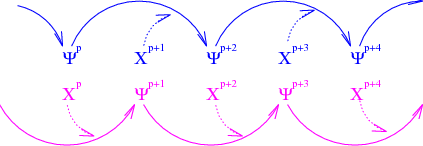

In [12]:
Image(filename='images/leapfrog.png',width='40%') 

<div id='fig:leap-frog'>
**Figure Leap-Frog Scheme:** A pictorial representation of the “leap-frog” character of the
time-stepping scheme. The values of $\chi$ at even time steps are linked
together with the odd $\Psi$ values; likewise, values of $\chi$ at odd
time steps are linked to the even $\Psi$ values.
</div>

There are two additional considerations related to the time
discretization:

-   The viscous terms ($\nabla_h^2\psi$ and $\nabla_h^4\psi$) are
    evaluated at the $p-1$ time points, while all other terms in the
    right hand side are evaluated at $p$ points. The reasoning for this
    is described in [McCalpin’s](#Ref:McCalpin) QGBOX
    documentation [p. 8]:

    > Note that the frictional terms are all calculated at the old
    $(n-1)$ time level, and are therefore first-order accurate in
    time. This ’time lagging’ is necessary for linear computational
    stability.

-   This second item *will not be implemented in this lab or the
    problems*, but should still be kept in mind …

    The leap-frog time-stepping scheme has a disadvantage in that it
    introduces a “computational mode” …  [McCalpin](#Ref:mccalpin) [p. 23]
    describes this as follows:

    > *Leap-frog models are plagued by a phenomenon called the
     “computational mode”, in which the odd and even time levels become
     independent. Although a variety of sophisticated techniques have
     been developed for dealing with this problem, McCalpin’s model
     takes a very simplistic approach. Every *narg* time
     steps, adjacent time levels are simply averaged together (where
     *narg*$\approx 100$ and odd)*

    Why don’t we just abandon the leap-frog scheme? Well, [Mesinger and Arakawa](#Ref:MesingerArakawa) [p. 18] make the following observations
    regarding the leap-frog scheme:

    -   its advantages: simple and second order accurate; neutral within
        the stability range.

    -   its disadvantages: for non-linear equations, there is a tendency
        for slow amplification of the computational mode.

    -   the usual method for suppressing the spurious mode is to insert
        a step from a two-level scheme occasionally (or, as McCalpin
        suggests, to occasionally average the solutions at successive
        time steps).

    -   In Chapter 4, they mention that it is possible to construct
        grids and/or schemes with the same properties as leap-frog and
        yet the computational mode is absent.

    The important thing to get from this is that when integrating for
    long times, the computational mode will grow to the point where it
    will pollute the solution, unless one of the above methods is
    implemented. For simplicity, we will not be worrying about this in
    Lab \#8.

### 5.4 Outline of Solution Procedure ###

Now that we have discretized in both space and time, it is possible to
outline the basic solution procedure.

1.  Assume that at $t=t_p$, we know $\Psi^0, \Psi^1, \dots,
      \Psi^{p-1}$

2.  Calculate $F_{i,j}^p$ for each grid point $(i,j)$ (see
    [Section 5.1.1 Right Hand Side](#5.1.1-Right-Hand-Side)). Keep in mind that the viscosity terms
    ($\nabla_h^2\psi$ and $\nabla_h^4\psi$) are evaluated at time level
    $p-1$, while all other terms are evaluated at time level $p$ (this
    was discussed in [Section 5.3 Temporal Discretization](#5.3-Temporal-Discretization).

3.  Solve the ([Discrete $\chi$ equation](#eq:discrete-chi)) for $\chi_{i,j}^p$ (the actual
    solution method will be described in [Section 5.2 Solution of the Poisson Equation by Relaxation](#5.2-Solution-of-the-Poisson-Equation-by-Relaxation).

4.  Given $\chi_{i,j}^p$, we can find $\Psi_{i,j}^{p+1}$ by using the
    ([Leap-frog time stepping scheme](#leapfrog))

5.  Let $p \leftarrow p+1$ and return to step 2.

Notice that step 1 requires a knowledge of two starting values, $\Psi^0$
and $\Psi^1$, at the initial time. An important addition to the
procedure below is some way to get two starting values for $\Psi$. Here
are several alternatives:

-   Set $\Psi^0$ and $\Psi^1$ both to zero.

-   Set $\Psi^0=0$, and then use a forward Euler step to find $\Psi^1$.

-   Use a predictor-corrector step, like that employed in Lab 7.

## *Problem Two* ##
> Now that you’ve seen how the basic
numerical scheme works, it’s time to jump into the numerical scheme. The
code has already been written for the discretization described above,
with free-slip boundary conditions and the SOR relaxation scheme. The
code is in **qg.py** and the various functions are:

>**main**
:   the main routine, contains the time-stepping and the output.

>**param()**
:   sets the physical parameters of the system.

>**numer\_init()**
:   sets the numerical parameters.

>**vis(psi, nx, ny)**
:   calculates the second order ($\nabla^2$) viscosity term (not
    leap-frogged).

>**wind(psi, nx, ny)**
:   calculates the the wind term.

>**mybeta(psi, nx, ny)**
:   calculates the beta term

>**jac(psi, vis, nx, ny)**
:   calculate the Jacobian term. (Arakawa Jacobian given here).

>**chi(psi, vis_curr, vis_prev, chi_prev, nx, ny, dx, r_coeff, tol, max_count, epsilon, wind_par, vis_par)**
:   calculates $\chi$ using a call to relax

>**relax(rhs, chi_prev, dx, nx, ny, r_coeff, tol, max_count)**
:   does the relaxation.




> Your task in this problem is to program the “straightforward”
discretization of the Jacobian term, using [(Jacobian: Expansion 1)](#eq:jaboc1), that you derived in
[Problem One](#Problem-One). The only change this involves is
inserting the code into the function **jac**. Once
finished, run the code. The parameter functions **param**
**init\_numer** provide some sample parameter values for you to
execute the code with. Try these input values and observe what happens
in the solution. Choose one of the physical parameters to vary. Does
changing the parameter have any effect on the solution? in what way?

> Hand in the code for the Jacobian, and a couple of plots demonstrating
the solution as a function of parameter variation. Describe your results
and make sure to provide parameter values to accompany your explanations
and plots.

>If the solution is unstable, check your CFL condition. The relevant
waves are Rossby waves with wave speed: $$c=\beta k^{-2}$$ where $k$ is
the wave-number. The maximum wave speed is for the longest wave,
$k=\pi/b$ where $b$ is the size fo your domain.

> If the code is still unstable, even though the CFL is satisfied, see
[Section 6. Aliasing Error and Nonlinear Instability](#6.-Aliasing-Error-and-Nonlinear-Instability). The solution is nonlinear unstable.
Switch to the Arakawa Jacobian for stability.

## *Problem Three* ## 
>The code provided for [Problem Two](#Problem-Two) implements the SOR relaxation
scheme. Your job in this problem is to modify the relaxation code to
perform a Jacobi iteration.

>Hand in a comparison of the two methods, in tabular form. Use two
different relaxation parameters for the SOR scheme. (Include a list of
the physical and numerical parameter you are using). Also submit your
code for the Jacobi relaxation scheme.

## *Problem Four* ##
> Modify the code to implement the no-slip boundary
conditions.

## *Problem Five* ##
>The code you’ve been working with so far uses the
simplest possible type of starting values for the unknown stream
function: both are set to zero. If you’re keen to play around with the
code, you might want to try modifying the SOR code for the two other
methods of computing starting values: using a forward Euler step, or a
predictor-corrector step (see [Section 5.4 Outline of Solution Procedure](#5.4-Outline-of-Solution-Procedure)).

## 6. Aliasing Error and Nonlinear Instability ##

In [Problem Two](#Problem-Two), you encountered an example
of the instability that can occur when computing numerical solutions to
some *nonlinear problems*, of which the QG equations is
just one example. This effect has in fact been known for quite some
time. Early numerical experiments by [N. Phillips in 1956](#Ref:Phillips)
exploded after approximately 30 days of integration due to nonlinear
instability. He used the straightforward centered difference formula for
as you did.

It is important to realize that this instability does not occur in the
physical system modeled by the equations of motion. Rather is an
artifact of the discretization process, something known as
*aliasing error*. Aliasing error can be best understood by
thinking in terms of decomposing the solution into modes. In brief,
aliasing error arises in non-linear problems when a numerical scheme
amplifies the high-wavenumber modes in the solution, which corresponds
physically to a spurious addition of energy into the system. Regardless
of how much the grid spacing is reduced, the resulting computation will
be corrupted, since a significant amount of energy is present in the
smallest resolvable scales of motion. This doesn’t happen for every
non-linear problem or every difference scheme, but is an issue that one
who is using numerical codes must be aware of.

## *Example One* ##

>Before moving on to how we can handle the
instability in our discretization of the QG equations, you should try
out the following demo on aliasing error. It is taken from an example in
[Mesinger and Arakawa](#Ref:MesingerArakawa) [p. 35ff.], based on the simplest
of non-linear PDE’s, the advection equation:
$$\frac{du}{dt}+u\frac{du}{dx} = 0.$$ If we decompose the solution into
Fourier mode, and consider a single mode with wavenumber $k$,
$$u(x) = \sin{kx}$$ then the solution will contain additional modes, due
to the non-linear term, and given by
$$u \frac{du}{dx} = k \sin{kx} \cos{kx} =\frac{1}{2}k \sin{2kx}.$$

>With this as an introduction, keep the following in mind while going
through the demo:

>-   on a computational grid with spacing $\Delta x$, the discrete
    versions of the modes can only be resolved up to a maximum
    wavenumber, $k_{max}=\frac{\pi}{\Delta x}$.

>-   even if we start with modes that are resolvable on the grid, the
    non-linear term introduces modes with a higher wavenumber, which may
    it not be possible to resolve. These modes, when evaluated at
    discrete points, appear as modes with lower wavenumber; that is,
    they are *aliased* to the lower modes (this becomes
    evident in the demo as the wavenumber is increased …).

>-   not only does aliasing occur, but for this problem, these additional
    modes are *amplified* by a factor of $\frac{1}{2}k$.
    This is the source of the *aliasing error* – such
    amplified modes will grow in time, no matter how small the time step
    taken, and will pollute the computations.

The previous example is obviously a much simpler non-linearity than that
of the QG equations, but the net effect is the same. The obvious
question we might ask now is:

> *Can this problem be averted for our discretization of the QG
> equations with the leap-frog time-stepping scheme, or do we have to
> abandon it?*

There are several possible solutions, presented by [Mesinger and Arakawa](#Ref:MesingerArakawa) [p. 37], summarized here, including

-   filter out the top half or third of the wavenumbers, so that the
    aliasing is eliminated.

-   use a differencing scheme that has a built-in damping of the
    shortest wavelengths.

-   the most elegant, and one that allows us to continue using the
    leap-frog time stepping scheme, is one suggested by Arakawa, is one
    that aims to eliminate the spurious inflow of energy into the system
    by developing a discretization of the Jacobian term that satisfies
    discrete analogues of the conservation properties for average
    vorticity, enstrophy and kinetic energy.
    
This third approach will be the one we take here. The details can be
found in the Mesinger-Arakawa paper, and are not essential here; the
important point is that there is a discretization of the Jacobian that
avoids the instability problem arising from aliasing error. This
discrete Jacobian is called the *Arakawa Jacobian* and is
obtained by averaging the discrete Jacobians obtained by using standard
centered differences on the formulae [(Jacobian: Expansion 1)](#eq:jacob1), [(Jacobian: Expansion 2)](#eq:jacob2) and [(Jacobian: Expansion 3)](#eq:jacob3) (see
[Problem One](#Problem-One) and the two quizzes following it in
[Section 5.1.1 Right Hand Side](#5.1.1-Right-Hand-Side).

You will not be required to derive or code the Arakawa Jacobian (the
details are messy!), and the code will be provided for you for all the
problems following [Problem Two](#Problem-Two).

## 7. Classical Solutions ##

[Bryan (1963)](#Ref:Bryan) and [Veronis (1966)](#Ref:Veronis)

## *Problem Six* ##
> Using the SOR code from
Problems [Three](#Problem-Three) (free-slip BC’s) and [Four](#Problem-Four)
(no-slip BC’s), try to reproduce the classical results of Bryan and
Veronis.

## A. Mathematical Notes ##

### A.1 Definition of the Beta-plane ###

A $\beta$-plane is a plane approximation of a curved section of the
Earth’s surface, where the Coriolis parameter, $f(y)$, can be written
roughly as a linear function of $y$ $$f(y) = f_0 + \beta y$$ for $f_0$
and $\beta$ some constants. The motivation behind this approximation
follows.

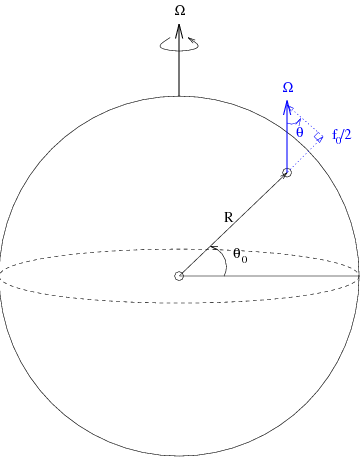

In [13]:
Image(filename='images/coriolis.png',width='30%') 

<div id='fig:globe'>
**Figure Rotating Globe:**
A depiction of the earth and its angular frequency of rotation,
$\Omega$, the local planetary vorticity vector in blue, and the Coriolis
parameter, $f_0$, at a latitude of $\theta_0$.
</div>

Consider a globe (the earth) which is rotating with angular frequency
$\Omega$ (see [Figure Rotating Globe](#fig:globe)),
and assume that the patch of ocean under consideration is at latitude
$\theta$. The most important component of the Coriolis force is the
local vertical (see the in [Figure Rotating Globe](#fig:globe)), which is defined in
terms of the Coriolis parameter, $f$, to be $$f/2 = \Omega \sin\theta.$$
This expression may be simplified somewhat by ignoring curvature effects
and approximating the earth’s surface at this point by a plane $-$ if
the plane is located near the middle latitudes, then this is a good
approximation. If $\theta_0$ is the latitude at the center point of the
plane, and $R$ is the radius of the earth (see
[Figure Rotating Globe](#fig:globe)), then we can apply trigonometric ratios to
obtain the following expression on the plane:
$$f = \underbrace{2\Omega\sin\theta_0}_{f_0} +
  \underbrace{\frac{2\Omega\cos\theta_0}{R}}_\beta \, y$$ Not
surprisingly, this plane is called a *mid-latitude
$\beta$-plane*.

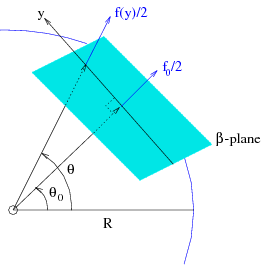

In [14]:
Image(filename='images/beta-plane.png',width='30%') 

<div id='fig:beta'>
**Figure Beta-plane:**
The $\beta$-plane approximation, with points on the plane located
along the local $y$-axis. The Coriolis parameter, $f$, at any latitude
$\theta$, can be written in terms of $y$ using trigonometric
ratios.</div>

### A.2 Simplification of the QG Model Equations ##

The first approximation we will make eliminates several of the
non-linear terms in the set of equations: ([X-Momentum Eqn](#eq:xmom)), ([Y-Momentum Eqn](#eq:ymom)), ([Hydrostatic Eqn](#eq:hydrostatic)) and ([Continuity Eqn](#eq:continuity)). A common simplification that is made in
this type of flow is the *quasi-geostrophic* (QG)
approximation, where the horizontal pressure gradient and horizontal
components of the Coriolis force are matched:
$$fv \approx \frac{1}{\rho} \, \frac {\partial p}{\partial x}, \, \, fu \approx - \,\frac{1}{\rho}
\, \frac{\partial p}{\partial y} .$$ 
Remembering that the fluid is homogeneous (the density is
constant), ([Continuity Eqn](#eq:continuity)) implies
$$\frac{\partial^2 p}{\partial x\partial z} = 0, \, \, \frac{\partial^2 p}{\partial y\partial z} = 0.$$ We can
then differentiate the QG balance equations to obtain
$$\frac{\partial v}{\partial z} \approx 0, \, \, \frac{\partial u}{\partial z} \approx 0.$$ Therefore, the terms
$w \, \partial u/\partial z$ and $w \, \partial v/\partial z$ can be neglected in ([(X-Momentum Eqn)](#eq:xmom)) and
([(Y-Momentum Eqn)](#eq:ymom)).

The next simplification is to eliminate the pressure terms in
([(X-Momentum Eqn)](#eq:xmom)) and
([(Y-Momentum Eqn)](#eq:ymom)) by cross-differentiating. If we define
the vorticity $$\zeta = \partial v/\partial x - \partial u/\partial y$$ then we can
cross-differentiate the two momentum equations and replace them with a
single equation in $\zeta$:
$$\frac{\partial \zeta}{\partial t} + u \frac{\partial \zeta}{\partial x} + v \frac{\partial \zeta}{\partial y} + v\beta + (\zeta+f)(\frac {\partial u}{\partial x}+\frac{\partial v}{\partial y}) =
A_v \, \frac{\partial^2 \zeta}{\partial z^2} + A_h \, \nabla_h^2 \zeta,$$ where
$\beta \equiv df/dy$. Notice the change in notation for derivatives,
from $\nabla$ to $\nabla_h$: this indicates that derivative now appear
only with respect to the “horizontal” coordinates, $x$ and $y$, since
the $z$-dependence in the solution has been eliminated.

The third approximation we will make is to assume that vorticity effects
are dominated by the Coriolis force, or that $|\zeta| \ll f$. Using
this, along with the ([Continuity Eqn](#eq:continuity)) implies that

<a name='eq:diff'></a>
(Vorticity Eqn)
$$\frac{\partial \zeta}{\partial t} + u \frac {\partial \zeta}{\partial x} + v \frac{\partial \zeta}{\partial y} + v \beta -f \, \frac{\partial w}{\partial z} = A_v \,
\frac{\partial^2 \zeta}{\partial z^2} + A_h \, \nabla_h^2 \zeta .$$ 
The reason for
making this simplification may not be obvious now but it is a good
approximation in flows in the ocean and, as we will see next, it allows
us to eliminate the Coriolis term.

The final sequence of simplifications eliminate the $z$-dependence in
the problem by integrating ([Vorticity Eqn](#eq:diff)) in the vertical direction and using boundary
conditions.

The top 500 metres of the ocean tend to act as a single slab-like layer.
The effect of stratification and rotation cause mainly horizontal
motion. To first order, the upper layers are approximately averaged flow
(while to the next order, surface and deep water move in opposition with
deep flow much weaker). Consequently, our averaging over depth takes
into account this “first order” approximation embodying the horizontal
(planar) motion, and ignoring the weaker (higher order) effects.

First, recognize that the vertical component of velocity on both the top
and bottom surfaces should be zero: $$w = 0 \;\;\; \mbox{at $z=0$}$$
$$w = 0 \;\;\; \mbox{at $z=-H$}$$ Notice that the in second
condition we’ve also assumed that the water surface is approximately
flat $-$ this is commonly known as the *rigid lid
approximation*. Integrate the differential equation ([Vorticity Eqn](#eq:diff)) with respect
to $z$, applying the above boundary conditions, and using the fact that
$u$ and $v$ (and therefore also $\zeta$) are independent of $z$,

<a name='vort-depth-integ'></a>
(Depth-Integrated Vorticity)
$$
  \frac{1}{H} \int_{-H}^0 \mbox{(Vorticity Eqn)} dz \Longrightarrow 
  \frac {\partial \zeta}{\partial t} + u \frac {\partial \zeta}{\partial x} + v \frac {\partial \zeta}{\partial y} + v\beta 
  = \frac{1}{H} \, \left( \left. A_v \, 
      \frac{\partial \zeta}{\partial z} \right|_{z=0} - \left.  A_v \, 
      \frac{\partial \zeta}{\partial z} \right|_{z=-H} \right) \, + A_h \, \nabla_h^2 \zeta
  $$

The two boundary terms on the right hand side can be rewritten in terms
of known information if we apply two additional boundary conditions: the
first, that the given wind stress on the ocean surface,
$$\vec{\tau}(x,y) = (\tau_1,\tau_2) \;\;\mbox{at }\;\; z=0,$$ can be
written as
$$\rho A_v \left( \frac{\partial u}{\partial z} , \frac{\partial v}{\partial z} \right) = \left( \tau_1 , \tau_2
  \right)$$ which, after differentiating, leads to
  
<a name='eq:stressbc'></a>
(Stress Boundary Condition)
$$\frac{1}{H} \, A_v \, \left. \frac{\partial \zeta}{\partial z} \right|_{z=0} = \frac{1}{\rho H} \,
  \nabla_h \times \tau \,;
  $$ and, the second, that the *Ekman
layer* along the bottom of the ocean, $z=-H$, generates Ekman
pumping which obeys the following relationship:

<a name='ekmanbc'></a>
(Ekman Boundary Condition)
$$\frac{1}{H} \, A_v \, \left. \frac{\partial \zeta}{\partial z} \right|_{z=-H} =
  \; \kappa \zeta, 
  $$ where the *Ekman number*,
$\kappa$, is defined by
$$\kappa \equiv  \frac{1}{H}  \left( \frac{A_v f}{2} \right)^{1/2}.$$
Using ([Stress Boundary Condition](#eq:stressbc)) and ([Ekman Boundary Condition](#ekmanbc)) to replace the boundary terms in ([Depth-Integrated Vorticity](#vort-depth-integ)), we get the following
equation for the vorticity:
$$\frac{\partial \zeta}{\partial t} + u \frac{\partial \zeta}{\partial x} + v \frac{\partial \zeta}{\partial y} + v \beta = \frac{1}{\rho H} \, \nabla_h 
\times \tau - \kappa \zeta + A_h \, \nabla_h^2 \zeta.$$

The next and final step may not seem at first to be much of a
simplification, but it is essential in order to derive a differential
equation that can be easily solved numerically. Integrate ([Continuity Eqn](#eq:continuity)) with respect
to $z$ in order to obtain $$\frac {\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0,$$ after which we can
introduce a *stream function*, $\psi$, defined in terms of
the velocity as
$$u = - \, \frac{\partial \psi}{\partial y} \, , \, v = \frac{\partial \psi}{\partial x}.$$ The
stream function satisfies this equation exactly, and we can write the
vorticity as $$\zeta = \nabla_h^2 \psi,$$ which then allows us to write
both the velocity and vorticity in terms of a single variable, $\psi$.

After substituting into the vorticity equation, we are left with a
single equation in the unknown stream function. $$
\frac{\partial}{\partial t} \, \nabla_h^2 \psi + {\cal J} \left( \psi, \nabla_h^2 \psi \right) + \beta \, \frac {\partial \psi}{\partial x} = \frac{-1}{\rho H} \, \nabla_h \times \tau  - \, \kappa \, \nabla_h^2 \psi + A_h \, \nabla_h^4 \psi $$
where
$${\cal J} (a,b) = \frac{\partial a}{\partial x} \, \frac{\partial b}{\partial y} - \frac{\partial a}{\partial y} \, \frac{\partial b}{\partial x}$$ is called the *Jacobian* operator.

The original system ([X-Momentum Eqn](#eq:xmom)), ([Y-Momentum Eqn](#eq:ymom)), ([Hydrostatic Eqn](#eq:hydrostatic)) and ([Continuity Eqn](#eq:continuity)) was a system of four non-linear PDE’s, in four
independent variables (the three velocities and the pressure), each of
which depend on the three spatial coordinates. Now let us review the
approximations made above, and their effects on this system:

1.  After applying the QG approximation and homogeneity, two of the
    non-linear terms were eliminated from the momentum equations, so
    that the vertical velocity, $w$, no longer appears.

2.  By introducing the vorticity, $\zeta$, the pressure was eliminated,
    and the two momentum equations to be rewritten as a single equation
    in $\zeta$ and the velocities.

3.  Some additional terms were eliminated by assuming that Coriolis
    effects dominate vorticity, and applying the continuity condition.

4.  Integrating over the vertical extent of the ocean, and applying
    boundary conditions eliminated the $z$-dependence in the problem.

5.  The final step consists of writing the unknown vorticity and
    velocities in terms of the single unknown stream function, $\psi$.

It is evident that the final equation is considerably simpler: it is a
single, non-linear PDE for the unknown stream function, $\psi$, which is
a function of only two independent variables. As we will see in the next
section, this equation is of a very common type, for which simple and
efficient numerical techniques are available.

## Glossary ##

- **advection:** A property or quantity transferred by the flow of a fluid is said to be “advected” by the flow.
aliasing error: In a numerical scheme, this is the phenomenon that occurs when a grid is not fine enough to resolve the high modes in a solution. These high waveumbers consequently appear as lower modes in the solution due to aliasing. If the scheme is such that these high wavenumber modes are amplified, then the aliased modes can lead to a significant error in the computed solution.
- **$\beta$-plane:** A $\beta$-plane is a plane approximation of a curved section of the Earth’s surface, where the Coriolis parameter can be written roughly as a linear function.
- **continuity equation:** The equation that describes mass conservation in a fluid, ${\partial \rho}/{\partial t} + \nabla \cdot (\rho \vec u) = 0$
- **Coriolis force:** An additional force experienced by an observer positioned in a rotating frame of reference. If $\Omega$ is the angular velocity of the rotating frame, and $\vec u$ is the velocity of an object observed within the rotating frame, then the Coriolis force, $\Omega \times \vec u$, appears as a force tending to deflect the moving object to the right.
- **Coriolis parameter:** The component of the planetary vorticity which is normal to the earth’s surface, usually denoted by f.
- **difference stencil:** A convenient notation for representing difference approximation formula for derivatives. 
- **Ekman layer:** The frictional layer in a geophysical fluid flow field which appears on a rigid surface perpendicular to the rotation vector.
- **Gauss-Seidel relaxation:** One of a class of iterative schemes for solving systems of linear equations. See Lab 8 for a complete discussion.
- **homogeneous fluid:** A fluid with constant density. Even though the density of ocean water varies with depth, it is often assumed homogeneous in order to simplify the equations of motion.
- **hydrostatic balance:** A balance, in the vertical direction, between the vertical pressure gradient and the buoyancy force. The pressure difference between any two points on a vertical line is assumed to depend only on the weight of the fluid between the points, as if the fluid were at rest, even though it is actually in motion. This approximation leads to a simplification in the equations of fluid flow, by replacing the vertical momentum equation.
- **incompressible fluid:** A fluid for which changes in the density with pressure are negligible. For a fluid with velocity field, $\vec u$, this is expressed by the equation $\nabla \cdot \vec u = 0$. This equation states that the local increase of density with time must be balanced by the divergence of the mass flux.
- **Jacobi relaxation:** The simplest of the iterative methods for solving linear systems of equations. See Lab 8 for a complete discussion.
- **momentum equation(s):** The equations representing Newton’s second law of motion for a fluid. There is one momentum equation for each component of the velocity.
- **over-relaxation:** Within a relaxation scheme, this refers to the use of a relaxation parameter $\mu > 1$. It accelerates the standard Gauss-Seidel relaxation by forcing the iterates to move closer to the actual solution.

- **Poisson equation:** The partial differential equation $\nabla^2 u = f$ or, written two dimensions, ${\partial^2 u}/{\partial x^2} + {\partial^2 u}/{\partial y^2} =f(x,y)$.
- **QG:** abbreviation for quasi-geostrophic.
- **quasi-geostrophic balance:** Approximate balance between the pressure gradient and the Coriolis Force.
- **relaxation:** A term that applies to a class of iterative schemes for solving large systems of equations. The advantage to these schemes for sparse matrices (compared to direct schemes such as Gaussian elimination) is that they operate only on the non-zero entries of the matrix. For a description of relaxation methods, see Lab 8.

- **rigid lid approximation:** Assumption that the water surface deflection is negligible in the continuity equation (or conservation of volume equation)
- **SOR:** see successive over-relaxation.
- **sparse system:** A system of linear equations whose matrix representation has a large percentage of its entries equal to zero.
- **stream function:** Incompressible, two-dimensional flows with velocity field $(u,v)$, may be described by a stream function, $\psi(x, y)$, which satisfies $u = −{\partial \psi}/{\partial y}, v = {\partial \psi}/{\partial x}$. These equations are a consequence of the incompressibility condition.
- **successive over-relaxation:** An iterative method for solving large systems of linear equations. See Lab 8 for a complete discussion.
- **under-relaxation:** Within a relaxation scheme, this refers to the use of a relaxation parameter $\mu < 1$. It is not appropriate for solving systems of equations directly, but does have some application to multigrid methods.
- **vorticity:** Defined to be the curl of the velocity field, $\zeta = \nabla \times \vec u$. In geophysical flows, where the Earth is a rotating frame of reference, the vorticity can be considered as the sum of a relative vorticity (the curl of the velocity in the nonrotating frame) and the planetary vorticity, $2 \Omega$. For these large-scale flows, vorticity is almost always present, and the planetary vorticity dominates.

## References ##

<div id='Ref:ArakawaLamb'>
Arakawa, A. and V. R. Lamb, 1981: A potential enstrophy and energy conserving scheme for the shallow water equations. Monthly Weather Review, 109, 18–36.
</div>
<div id="Ref:Bryan">
Bryan, K., 1963: A numerical investigation of a non-linear model of a wind-driven ocean. Journal of Atmospheric Science, 20, 594–606</div>
<div id="Ref:McCalpin">
On the adjustment of azimuthally perturbed vortices. Journal of Geophysical Research, 92, 8213–8225.
</div>
<div id="Ref:MesingerArakawa">
Mesinger, F. and A. Arakawa, 1976: Numerical Methods Used in Atmospheric Models,GARP Publications Series No.~17, Global Atmospheric Research Programme.
</div>
<div id="Ref:Pedlosky">
Pedlosky, J., 1987: Geophysical Fluid Dynamics. Springer-Verlag, New York, 2nd edition.Pond, 
</div>
<div id="Ref:Phillips">
Phillips, N. A., 1956: The general circulation of the atmosphere: A numerical experiment.
Quarterly Journal of the Royal Meteorological Society, 82, 123–164.
</div>
<div id="Ref:Strang">
Strang, G., 1988: Linear Algebra and its Applications. Harcourt Brace Jovanovich, San Diego,
CA, 2nd edition.
</div>
<div id="Ref:Veronis">
Veronis, G., 1966: Wind-driven ocean circulation – Part 2. Numerical solutions of the non- linear problem. Deep Sea Research, 13, 31–55.
</div>